In [ ]:
# Setting working direcotry to the root of the project for the purpose of demonstration 
import os, sys; os.chdir(os.path.dirname(os.path.abspath(__file__))); sys.path.append('..')
pass

In [4]:
import itertools
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import seaborn as sns
import sklearn.datasets
from sklearn.model_selection import train_test_split

import netrep

## Exploring various netrep functions using the same example data as the netrep repo

### Synthetic data generation

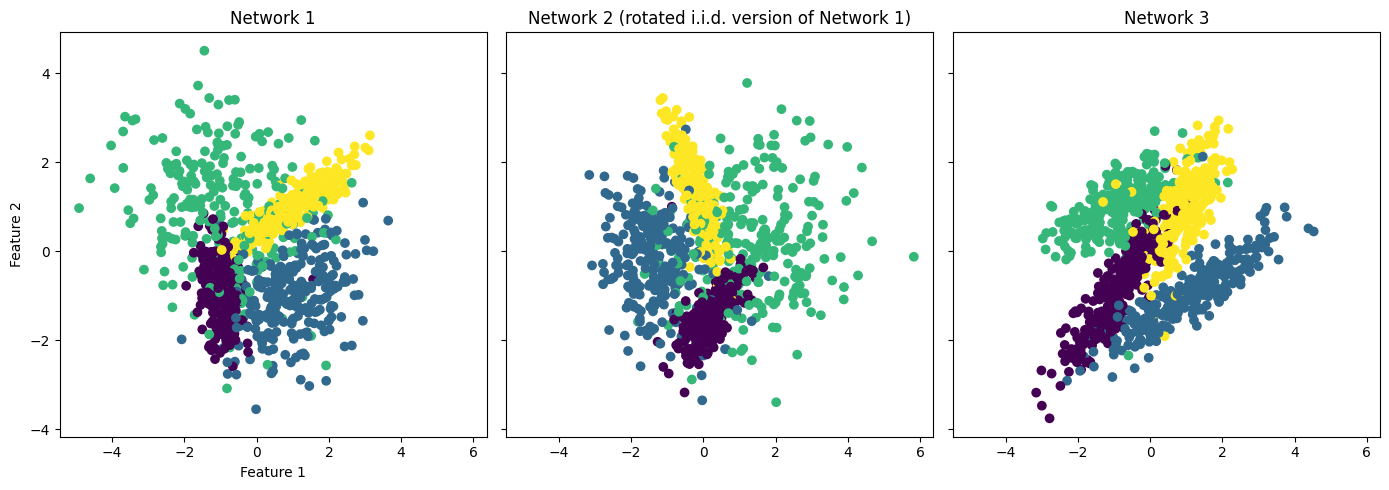

In [5]:
seed = 42069
n_samples = 2048
n_classes = 4  # Number of stimuli M
n_features = 2  # Dimensionality of responses N

rng = np.random.default_rng(seed)

_X, _y = sklearn.datasets.make_classification(
    n_samples=n_samples, 
    n_features=n_features, 
    n_informative=n_features, 
    n_redundant=0, 
    n_repeated=0, 
    n_classes=n_classes, 
    n_clusters_per_class=1, # Meaning: each class is a single cluster
    random_state=seed,
 )

# Split _X and _y into two disjoint sets (X1, y) and (X2, y2)
X1, X2, y1, y2 = train_test_split(_X, _y, test_size=0.5, random_state=seed, shuffle=True, stratify=None)

# Randomly rotate X2
Q, _ = np.linalg.qr(rng.standard_normal((2, 2))) # Meaning: Q is a random rotation matrix
X2 = X2 @ Q.T # Meaning: rotate X2 by Q

# Create different set of neural responses
X3, y3 = sklearn.datasets.make_classification(
    n_samples=n_samples//2, # Meaning: half the number of samples cuz it's not going to split
    n_features=n_features, 
    n_informative=n_features, 
    n_redundant=0, 
    n_repeated=0, 
    n_classes=n_classes, 
    n_clusters_per_class=1,
    random_state=420,
 )

X = (X1, X2, X3)
y = (y1, y2, y3)

# Plot them
fig, ax = plt.subplots(1, 3, figsize=(14, 5), sharex="all", sharey="all")
ax[0].scatter(*X1.T, c=y1)
ax[1].scatter(*X2.T, c=y2)
ax[2].scatter(*X3.T, c=y3)

ax[0].set(title="Network 1", xlabel="Feature 1", ylabel="Feature 2")
ax[1].set(title="Network 2 (rotated i.i.d. version of Network 1)")
ax[2].set(title="Network 3")
fig.tight_layout()

### Testing pairwise_distances

### EnergyStochasticMetric()

#### They are segrigated by class (by using ground truth y), then by sample, then by feature
example shapes (Xi, Xj): ((4, 225, 2), (4, 225, 2))

In [6]:
from netrep.metrics.stochastic import EnergyStochasticMetric

In [7]:
def reshape_data(X, y, samples_per_class):
    """Helper method to reshape data for EnergyStochasticMetric()."""
    
    M = len(np.unique(y))  # number of classes
    
    X0 = [X[y==i] for i in range(M)] # Meaning: X0 is a list of the data for each class
    X0 = np.stack([x[:samples_per_class] for x in X0], 0) # Meaning: take the first samples_per_class samples for each class
    
    print(f"after sampleing: X0 length: {len(X0)} classes with {len(X0[0])} samples each")

    return X0

In [8]:
from netrep.multiset import pairwise_distances

In [11]:
samples_per_class = 100

In [19]:
Xs = [reshape_data(X[0], y[0], samples_per_class), reshape_data(X[1], y[1], samples_per_class), reshape_data(X[2], y[2], samples_per_class)]

after sampleing: X0 length: 4 classes with 100 samples each
after sampleing: X0 length: 4 classes with 100 samples each
after sampleing: X0 length: 4 classes with 100 samples each


In [20]:
metric = EnergyStochasticMetric()
distmat_energy = pairwise_distances(metric, Xs, verbose=False)

In [27]:
def plot_distmat(distmat):
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    im = ax.imshow(distmat)

    number_of_networks = len(distmat[0])

    labels = [f"Network {i+1}" for i in range(number_of_networks)]

    ax.set_xticks(np.arange(number_of_networks))
    ax.set_yticks(np.arange(number_of_networks))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)

    ax.set(title="Energy distance", xticklabels=labels, yticklabels=labels)
    plt.colorbar(im)
    plt.show()

In [65]:
def plot_distmat(distmat, title = "Distance Metric", size = 5):
    '''Plot a distance matrix'''

    # Create a figure and a 3D Axes
    fig, ax = plt.subplots(1, 1, figsize=(size, size))
    im = ax.imshow(distmat)

    # Set the x and y ticks to the labels
    number_of_networks = len(distmat[0])

    labels = [f"Network {i+1}" for i in range(number_of_networks)]

    ax.set_xticks(np.arange(number_of_networks))
    ax.set_yticks(np.arange(number_of_networks))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)

    # rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations.
    for i in range(number_of_networks):
        for j in range(number_of_networks):

            # Show only 3 decimal places
            text = ax.text(j, i, f"{distmat[i, j]:.3f}", ha="center", va="center", color="w")
            
            # set text size to fit in the box dynamically
            text.set_size(1.0 / (number_of_networks * 0.5) * 12)
    
    ax.set(title=title)
    plt.colorbar(im)
    plt.show()

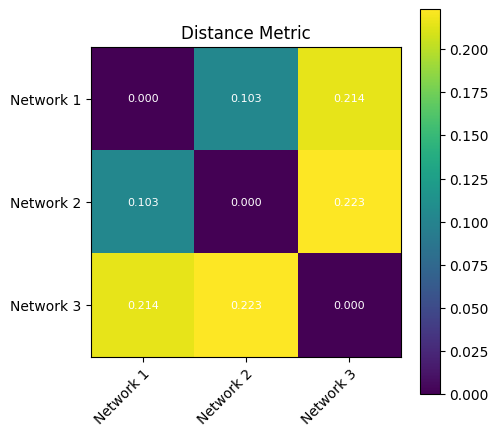

In [64]:
plot_distmat(distmat_energy)

In [17]:
distmat_energy

array([[0.]])

In [68]:
min(y[0])

0